In [1]:
import pandas as pd
import numpy as np
import pyarrow.parquet as pq
import os
import airportsdata 
from geopy.distance import geodesic

import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import pycountry
import pycountry_convert as pc
import plotly.io as pio
import seaborn as sns


# 1. Data Preparation

In [2]:
# Load provided air data from 2021
dataset = pq.ParquetDataset('c:\\Users\\lukas\\OneDrive - Imperial College London\\0_Sustainable Transport\\2021_COP26',
                            ) # filters=[('columnName', 'in', filterList)]
df = dataset.read(use_threads=True).to_pandas()

In [3]:
path_flights = os.getcwd() + '/data/data_flight_economy_business.xlsx'

data_all = pd.read_excel(path_flights,sheet_name='combined')
data_direct = pd.read_excel(path_flights,sheet_name='direct')
data_non_direct = pd.read_excel(path_flights,sheet_name='non_direct')

airports = airportsdata.load()

In [4]:
data_all.columns

Index(['origin_airport', 'total_delegates', 'destination_airport',
       'assumed_load_factor', 'aircraft_type_icao', 'total_fuel_burn',
       'co2_kg', 'nox_kg', 'hc_kg', 'oc_kg', 'h2o_kg', 'so2_kg',
       'sulphates_kg', 'Split Econ/Busi', 'Seats Economy', 'Seats Business',
       'total_kg_co2', 'pp_kg_co2'],
      dtype='object')

In [5]:
df.columns

Index(['callsign', 'icao_address', 'flight_number', 'tail_number',
       'aircraft_type_icao', 'aircraft_engine_type', 'origin_airport',
       'origin_airport_name', 'origin_country', 'destination_airport',
       'destination_airport_name', 'destination_country',
       'scheduled_departure_time_utc', 'scheduled_arrival_time_utc',
       'first_waypoint_time', 'last_waypoint_time', 'duration_hours',
       'total_distance_km', 'great_circle_distance_km',
       'longitude_first_waypoint', 'longitude_last_waypoint', 'longitude_min',
       'longitude_max', 'latitude_first_waypoint', 'latitude_last_waypoint',
       'latitude_min', 'latitude_max', 'altitude_first_waypoint',
       'altitude_last_waypoint', 'altitude_min', 'altitude_max', 'n_wypts',
       'n_terrestrial', 'n_satellites', 'n_interpolate', 'n_extrapolate',
       'n_great_circle', 'extrap_trajectory_start', 'extrap_trajectory_end',
       'trajectory_complete', 'great_circle_trajectory', 'est_origin_airport',
       'es

In [6]:
range(0, 178)

range(0, 178)

In [7]:
data_all['duration_hours'] = 0

TESTING TO USE DURATION HOURS

In [10]:
# Calculate mean duration hours for the first 179 rows
mean_duration_first = data_all.iloc[:179].apply(
    lambda row: df[(df.iloc[:, 4] == row[4]) & 
                   (df.iloc[:, 6] == row[0]) &
                   (df.iloc[:, 9] == row[2]) & 
                   (df.iloc[:, 55] == row[3])]['duration_hours'].mean(),
    axis=1
)

# Calculate mean duration hours for the remaining rows
mean_duration_remaining = data_all.iloc[179:].apply(
    lambda row: df[(df.iloc[:, 4] == row[4]) & 
                   (df.iloc[:, 6] == row[0]) &
                   (df.iloc[:, 9] == 'OMDB') & 
                   (df.iloc[:, 55] == row[3])]['duration_hours'].mean(),
    axis=1
)

# Assign mean duration hours to the DataFrame
data_all['duration_hours'] = pd.concat([mean_duration_first, mean_duration_remaining])


C:\Users\lukas\AppData\Local\Temp\ipykernel_13604\3542232524.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  lambda row: df[(df.iloc[:, 4] == row[4]) &
C:\Users\lukas\AppData\Local\Temp\ipykernel_13604\3542232524.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  (df.iloc[:, 6] == row[0]) &
C:\Users\lukas\AppData\Local\Temp\ipykernel_13604\3542232524.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  (df.iloc[:, 9] == row[2]) 

In [11]:
data_all

,origin_airport,total_delegates,destination_airport,assumed_load_factor,aircraft_type_icao,total_fuel_burn,co2_kg,nox_kg,hc_kg,oc_kg,h2o_kg,so2_kg,sulphates_kg,Split Econ/Busi,Seats Economy,Seats Business,total_kg_co2,pp_kg_co2,duration_hours
0,OMAA,8786,OMDB,0.529896,DH8D,466.979806,1475.189208,7.070074,0.242829,0.009340,574.385162,0.560376,0.011436,0.128205,36,5,3.172736e+05,71.960449,0.44
1,SBGR,3618,OMDB,0.787394,B77W,117028.001705,369691.457386,2653.651550,11.064843,2.340560,143944.442097,140.433602,2.865992,0.098361,303,33,1.315651e+07,1731.575913,13.91
2,ZBAA,2640,OMDB,0.641342,B77L,52082.273957,164527.903430,961.016159,6.623664,1.041645,64061.196967,62.498729,1.275484,0.180672,125,28,4.811404e+06,1382.587424,8.27
3,WIII,1229,OMDB,0.637657,B77W,52290.480217,165185.627004,1076.737713,7.272460,1.045810,64317.290666,62.748576,1.280583,0.098361,245,27,9.508812e+05,773.703171,7.41
4,RJTT,1221,OMDB,0.645028,B77L,72779.497786,229910.433506,1418.160959,7.370945,1.455590,89518.782277,87.335397,1.782355,0.180672,126,28,5.083146e+06,1932.020450,10.82
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271,KMIA,0,KMIA,0.751742,B77W,114219.191624,360818.426340,2563.752966,9.649549,2.284384,140489.605698,137.063030,2.797205,0.098361,289,32,2.248090e+03,0.000000,13.61
272,KMIA,0,KMIA,0.751742,B77W,114219.191624,360818.426340,2563.752966,9.649549,2.284384,140489.605698,137.063030,2.797205,0.098361,289,32,2.248090e+03,0.000000,13.61
273,LEBL,0,LEBL,0.698774,B77W,42317.352958,133680.517994,869.466243,6.217029,0.846347,52050.344138,50.780824,1.036343,0.098361,269,29,8.971847e+02,0.000000,5.89
274,HRYR,0,HRYR,0.606079,A332,26776.622897,84587.351733,374.152490,2.358692,0.535532,32935.246164,32.131947,0.655754,0.065972,163,12,9.667126e+02,0.000000,5.46


In [13]:
data_all['duration_hours'].isnull().sum()

7

In [15]:
data_all.dropna(subset=['Seats Economy', 'Seats Business'], inplace=True)

# Convert 'Seats Economy' and 'Seats Business' to integers
data_all['Seats Economy'] = data_all['Seats Economy'].astype(int)
data_all['Seats Business'] = data_all['Seats Business'].astype(int)

# data_all['Seats Economy'] = data_all['Seats Economy'] * data_all['assumed_load_factor']
# data_all['Seats Business'] = data_all['Seats Business'] * data_all['assumed_load_factor']


Get latitude and longitude for origin and destination

In [16]:
def get_coordinates(row, column_name):
    airport_code = row[column_name]
    airport_info = airports.get(airport_code)
    if airport_info:
        return pd.Series([airport_info['lat'], airport_info['lon']])
    else:
        print("airport miss")
        # print(data_all.loc[row])
        return pd.Series([None, None])

# Apply the function to get latitude and longitude for origin and destination airports
data_all[['origin_lat', 'origin_lon']] = data_all.apply(lambda row: get_coordinates(row, 'origin_airport'), axis=1)
data_all[['dest_lat', 'dest_lon']] = data_all.apply(lambda row: get_coordinates(row, 'destination_airport'), axis=1)


airport miss
airport miss
airport miss


Calculate distance between origin and destination

In [17]:
def calculate_distance(row):
    origin_coord = (row['origin_lat'], row['origin_lon'])
    dest_coord = (row['dest_lat'], row['dest_lon'])
    return geodesic(origin_coord, dest_coord).kilometers

# Drop rows with NaN values in latitude and longitude columns
data_all.dropna(subset=['origin_lat', 'origin_lon', 'dest_lat', 'dest_lon'], inplace=True)

# Apply the function to calculate distances
data_all['distance_km'] = data_all.apply(calculate_distance, axis=1)

data_all.iloc[:3]

,origin_airport,total_delegates,destination_airport,assumed_load_factor,aircraft_type_icao,total_fuel_burn,co2_kg,nox_kg,hc_kg,oc_kg,...,Seats Economy,Seats Business,total_kg_co2,pp_kg_co2,duration_hours,origin_lat,origin_lon,dest_lat,dest_lon,distance_km
0,OMAA,8786,OMDB,0.529896,DH8D,466.979806,1475.189208,7.070074,0.242829,0.009340,...,36,5,3.172736e+05,71.960449,0.44,24.433001,54.651100,25.2528,55.364399,115.950338
1,SBGR,3618,OMDB,0.787394,B77W,117028.001705,369691.457386,2653.651550,11.064843,2.340560,...,303,33,1.315651e+07,1731.575913,13.91,-23.435556,-46.473057,25.2528,55.364399,12217.959202
2,ZBAA,2640,OMDB,0.641342,B77L,52082.273957,164527.903430,961.016159,6.623664,1.041645,...,125,28,4.811404e+06,1382.587424,8.27,40.080101,116.584999,25.2528,55.364399,5855.097793


In [18]:
dubai_airport = pd.DataFrame({'dest_lat_A': [airports.get('OMDB')['lat']],
                     'origin_lon_A': [airports.get('OMDB')['lon']]})

delegate_airports = data_all[['dest_lat','origin_lon']]

# Function to calculate distance using geopy.distance
def calculate_distance(row):
    coord_A = (dubai_airport['dest_lat_A'].iloc[0], dubai_airport['origin_lon_A'].iloc[0])
    coord_B = (row['dest_lat'], row['origin_lon'])
    return geodesic(coord_A, coord_B).kilometers

data_all.loc[data_all['origin_airport'] == data_all['destination_airport'], 'distance_km'] = delegate_airports.apply(calculate_distance,axis=1).astype(np.int64)
data_all.iloc[:3]

,origin_airport,total_delegates,destination_airport,assumed_load_factor,aircraft_type_icao,total_fuel_burn,co2_kg,nox_kg,hc_kg,oc_kg,...,Seats Economy,Seats Business,total_kg_co2,pp_kg_co2,duration_hours,origin_lat,origin_lon,dest_lat,dest_lon,distance_km
0,OMAA,8786,OMDB,0.529896,DH8D,466.979806,1475.189208,7.070074,0.242829,0.009340,...,36,5,3.172736e+05,71.960449,0.44,24.433001,54.651100,25.2528,55.364399,115.950338
1,SBGR,3618,OMDB,0.787394,B77W,117028.001705,369691.457386,2653.651550,11.064843,2.340560,...,303,33,1.315651e+07,1731.575913,13.91,-23.435556,-46.473057,25.2528,55.364399,12217.959202
2,ZBAA,2640,OMDB,0.641342,B77L,52082.273957,164527.903430,961.016159,6.623664,1.041645,...,125,28,4.811404e+06,1382.587424,8.27,40.080101,116.584999,25.2528,55.364399,5855.097793


Calculate CO2 per person

In [19]:
factor_business = 4.025

data_all['total_seats'] = data_all['Seats Economy'] + data_all['Seats Business'] 
data_all['total_seats_factor_business'] = (data_all['Seats Economy'] + data_all['Seats Business'] * factor_business)

data_all['economy_co2_pp'] = (data_all['co2_kg'] * data_all['Seats Economy'] / data_all['total_seats_factor_business']) / data_all['Seats Economy']
data_all['business_co2_pp'] = (data_all['co2_kg'] * data_all['Seats Business'] * factor_business /  data_all['total_seats_factor_business']) / data_all['Seats Business']

In [23]:
# Assuming data_all is your DataFrame containing the relevant columns

# Count occurrences of each aircraft type before grouping
occurrences = data_all['aircraft_type_icao'].value_counts().reset_index()
occurrences.columns = ['aircraft_type_icao', 'occurrences']

# Grouping by aircraft_type_icao and calculating the average of other columns
grouped_data = data_all.groupby('aircraft_type_icao').agg({
    'total_seats': lambda x: round(x.mean(), 1),
    'distance_km': lambda x: round(x.mean(), 1),
    'total_fuel_burn': lambda x: round(x.mean(), 1),
    'duration_hours': lambda x: round(x.mean(),1)
}).reset_index()

# Merge the occurrences information with grouped_data
grouped_data = pd.merge(grouped_data, occurrences, on='aircraft_type_icao', how='left')

# print(grouped_data)

In [61]:
# Define a function to check if the duration is less than 3 hours
def is_short_haul(duration_hours):
    # Check if duration_hours is not NaN and less than 3 hours
    return (not pd.isna(duration_hours)) and duration_hours < 3

# Apply the function to create a new column 'is_short_haul' based on 'duration_hours'
grouped_data['is_short_haul'] = grouped_data['duration_hours'].apply(is_short_haul)
# data_all['is_short_haul'] = data_all['duration_hours'].apply(is_short_haul)
grouped_data.iloc[:3]

,aircraft_type_icao,total_seats,distance_km,total_fuel_burn,duration_hours,occurrences,is_short_haul
0,A20N,100.0,2338.7,5729.6,2.9,3,True
1,A21N,124.0,2576.2,8190.8,3.4,4,False
2,A310,128.0,874.5,5839.9,1.4,1,True


In [27]:
# # Definitely long haul : A359, A388, B77L, B77W, B788,
# short_medium_aircraft = ['A20N','A21N','B38M','B734','B748','B752','B763','BCS3','DC87','E190','RJ85','E290','B733',]
# short_haul_aircraft = ['A310','A319','A320','A321','A333','AT72','AT76','AT75','B735','B737','B738','B737','E190','B762','CRJ2','D228','DH8D','E145','E170',
#                        'A20N','A21N','B734','B752','B763','DC87','RJ85']

# # Define a function to check if the aircraft_type_icao is in the short_haul_aircraft list
# def is_short_haul(aircraft_type):
#     return aircraft_type in short_haul_aircraft

# # Apply the function to create a new column 'is_short_haul'
# grouped_data['is_short_haul'] = grouped_data['aircraft_type_icao'].apply(is_short_haul)
# data_all['is_short_haul'] = data_all['aircraft_type_icao'].apply(is_short_haul)

In [62]:
# data_all[data_all['is_short_haul'] == True]
grouped_data[grouped_data['is_short_haul'] == True]

,aircraft_type_icao,total_seats,distance_km,total_fuel_burn,duration_hours,occurrences,is_short_haul
0,A20N,100.0,2338.7,5729.6,2.9,3,True
2,A310,128.0,874.5,5839.9,1.4,1,True
3,A319,92.0,1494.0,4740.8,2.1,6,True
4,A320,102.6,1904.2,4761.9,2.1,10,True
7,A333,132.4,1988.3,13425.3,2.6,7,True
10,AT72,46.0,286.2,519.4,0.8,1,True
11,AT75,48.0,101.0,298.9,0.4,1,True
12,AT76,45.8,2228.6,636.5,1.1,4,True
16,B735,104.0,296.2,1350.5,0.6,2,True
17,B737,126.3,1495.3,4737.6,2.1,3,True


Assign delegate number to flight from hub-airport to Dubai

In [63]:
data_all['total_delegats_inc_hub'] = data_all['total_delegates']

In [64]:

occurrence_count = {}

# Replace zeros in the value column with the nth occurrence value for each reference value
for index, row in data_all.iterrows():
    if row['total_delegates'] == 0:
        reference_value = row['destination_airport']
        if reference_value not in occurrence_count:
            occurrence_count[reference_value] = 0
        else:
            occurrence_count[reference_value] += 1
        nth_occurrence = occurrence_count[reference_value]
        replacement_value = data_all[data_all['destination_airport'] == reference_value]['total_delegates'].iloc[nth_occurrence]
        data_all.at[index, 'total_delegats_inc_hub'] = replacement_value


In [65]:
print('Total delegates: ',data_all['total_delegates'].sum())
print('Total delegates with people who have to travel twice: ',data_all['total_delegats_inc_hub'].sum())

Total delegates:  79872
Total delegates with people who have to travel twice:  96413


## 1.1 Calculating CO2 Emission

In [66]:
data_all['total_co2'] = (data_all['total_delegats_inc_hub'] / (data_all['Seats Business'] + data_all['Seats Economy'])) * data_all['co2_kg'] * 2 # two directions

In [67]:
data_all

,origin_airport,total_delegates,destination_airport,assumed_load_factor,aircraft_type_icao,total_fuel_burn,co2_kg,nox_kg,hc_kg,oc_kg,...,dest_lat,dest_lon,distance_km,total_seats,total_seats_factor_business,economy_co2_pp,business_co2_pp,is_short_haul,total_delegats_inc_hub,total_co2
0,OMAA,8786,OMDB,0.529896,DH8D,466.979806,1475.189208,7.070074,0.242829,0.009340,...,25.252800,55.364399,115.950338,41,56.125,26.283995,105.793079,True,8786,6.322445e+05
1,SBGR,3618,OMDB,0.787394,B77W,117028.001705,369691.457386,2653.651550,11.064843,2.340560,...,25.252800,55.364399,12217.959202,336,435.825,848.256657,3414.233043,False,3618,7.961570e+06
2,ZBAA,2640,OMDB,0.641342,B77L,52082.273957,164527.903430,961.016159,6.623664,1.041645,...,25.252800,55.364399,5855.097793,153,237.700,692.166190,2785.968916,False,2640,5.677826e+06
3,WIII,1229,OMDB,0.637657,B77W,52290.480217,165185.627004,1076.737713,7.272460,1.045810,...,25.252800,55.364399,6543.696070,272,353.675,467.054858,1879.895805,False,1229,1.492744e+06
4,RJTT,1221,OMDB,0.645028,B77L,72779.497786,229910.433506,1418.160959,7.370945,1.455590,...,25.252800,55.364399,7949.313707,154,238.700,963.177350,3876.788835,False,1221,3.645723e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271,KMIA,0,KMIA,0.751742,B77W,114219.191624,360818.426340,2563.752966,9.649549,2.284384,...,25.795361,-80.290116,12625.000000,321,417.800,863.615190,3476.051139,False,74,1.663587e+05
272,KMIA,0,KMIA,0.751742,B77W,114219.191624,360818.426340,2563.752966,9.649549,2.284384,...,25.795361,-80.290116,12625.000000,321,417.800,863.615190,3476.051139,False,0,0.000000e+00
273,LEBL,0,LEBL,0.698774,B77W,42317.352958,133680.517994,869.466243,6.217029,0.846347,...,41.297100,2.078460,5183.000000,298,385.725,346.569494,1394.942213,False,0,0.000000e+00
274,HRYR,0,HRYR,0.606079,A332,26776.622897,84587.351733,374.152490,2.358692,0.535532,...,-1.968630,30.139500,4058.000000,175,211.300,400.318749,1611.282966,False,233,2.252440e+05


## 1.2 Long and short haul flights

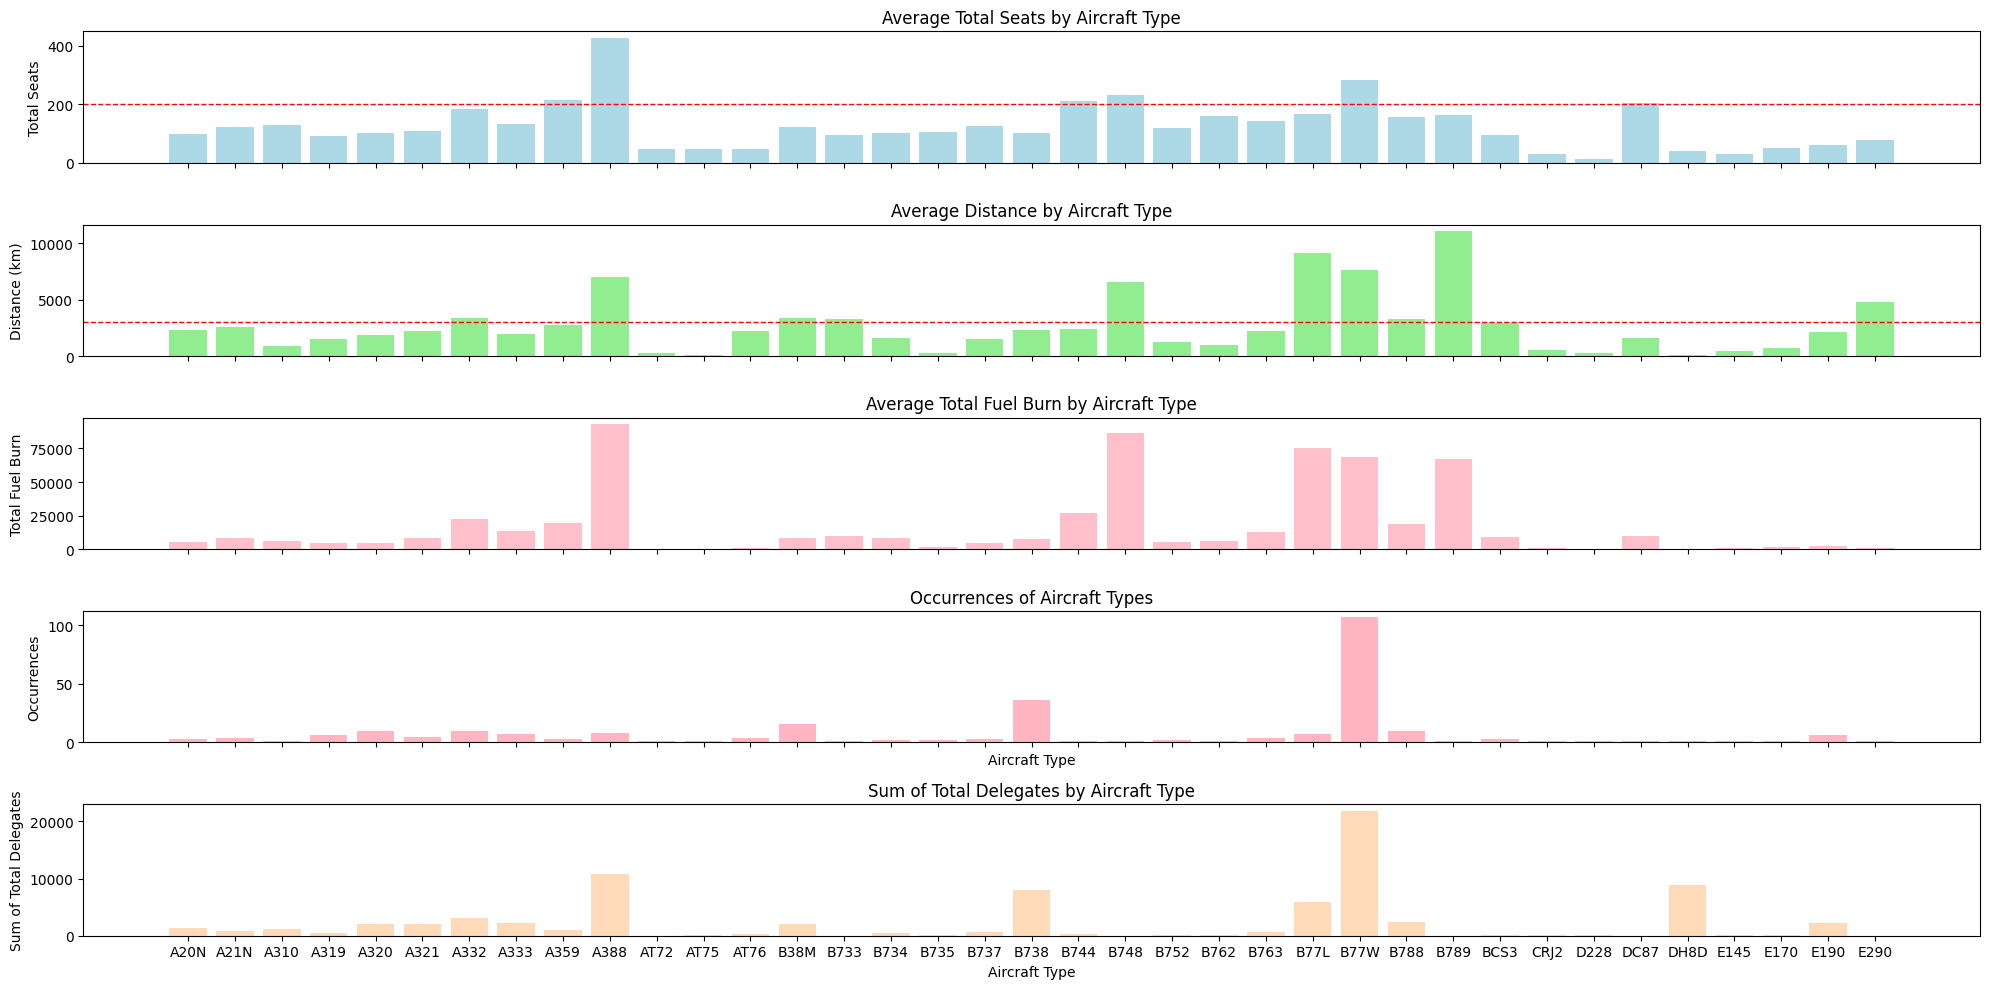

In [68]:
# Create a figure with subplots
fig, axs = plt.subplots(5, 1, figsize=(20, 10),sharex=True)


# Plotting total seats
for index, row in grouped_data.iterrows():
    color = 'lightblue' if row['aircraft_type_icao'] not in short_haul_aircraft else 'blue'
    axs[0].bar(row['aircraft_type_icao'], row['total_seats'], color=color)

axs[0].set_title('Average Total Seats by Aircraft Type')
# axs[0].set_xlabel('Aircraft Type')
axs[0].set_ylabel('Total Seats')
axs[0].axhline(y=200, color='red', linestyle='--', linewidth=1)  # Adding the limit line at 200


# Plotting distance
for index, row in grouped_data.iterrows():
    color = 'lightgreen' if row['aircraft_type_icao'] not in short_haul_aircraft else 'green'
    axs[1].bar(row['aircraft_type_icao'], row['distance_km'], color=color)

axs[1].set_title('Average Distance by Aircraft Type')
# axs[1].set_xlabel('Aircraft Type')
axs[1].set_ylabel('Distance (km)')
axs[1].axhline(y=3000, color='red', linestyle='--', linewidth=1)  # Adding the limit line at 3000


# Plotting total fuel burn
for index, row in grouped_data.iterrows():
    color = 'pink' if row['aircraft_type_icao'] not in short_haul_aircraft else 'red'
    axs[2].bar(row['aircraft_type_icao'], row['total_fuel_burn'], color=color)

axs[2].set_title('Average Total Fuel Burn by Aircraft Type')
# axs[2].set_xlabel('Aircraft Type')
axs[2].set_ylabel('Total Fuel Burn')

# Plotting occurrences
for index, row in grouped_data.iterrows():
    color = 'LIGHTPINK' if row['aircraft_type_icao'] not in short_haul_aircraft else 'magenta'
    axs[3].bar(row['aircraft_type_icao'], row['occurrences'], color=color)

axs[3].set_title('Occurrences of Aircraft Types')
axs[3].set_xlabel('Aircraft Type')
axs[3].set_ylabel('Occurrences')
axs[3].tick_params(axis='x', which='both', bottom=True, top=False)  # Show x-axis ticks only for axs[3]

# Calculate the sum of total delegates for each aircraft type
total_delegates_sum = data_all.groupby('aircraft_type_icao')['total_delegates'].sum()

for aircraft_type in total_delegates_sum.index:
    color = 'peachpuff' if aircraft_type not in short_haul_aircraft else 'orange'  # Using lightsalmon for short haul
    axs[4].bar(aircraft_type, total_delegates_sum[aircraft_type], color=color)

axs[4].set_title('Sum of Total Delegates by Aircraft Type')
axs[4].set_xlabel('Aircraft Type')
axs[4].set_ylabel('Sum of Total Delegates')




# Rotate x-axis labels for better readability if necessary
# plt.setp(axs[3].xaxis.get_majorticklabels(), rotation=45)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


In [69]:
short_haul_mask = grouped_data['duration_hours'].apply(is_short_haul)

# Get the array of aircraft_type_icao where the condition is True
short_haul_aircraft = grouped_data.loc[short_haul_mask, 'aircraft_type_icao'].values
short_haul_aircraft

array(['A20N', 'A310', 'A319', 'A320', 'A333', 'AT72', 'AT75', 'AT76',
       'B735', 'B737', 'B752', 'B762', 'CRJ2', 'D228', 'DC87', 'DH8D',
       'E145', 'E170', 'E190'], dtype=object)

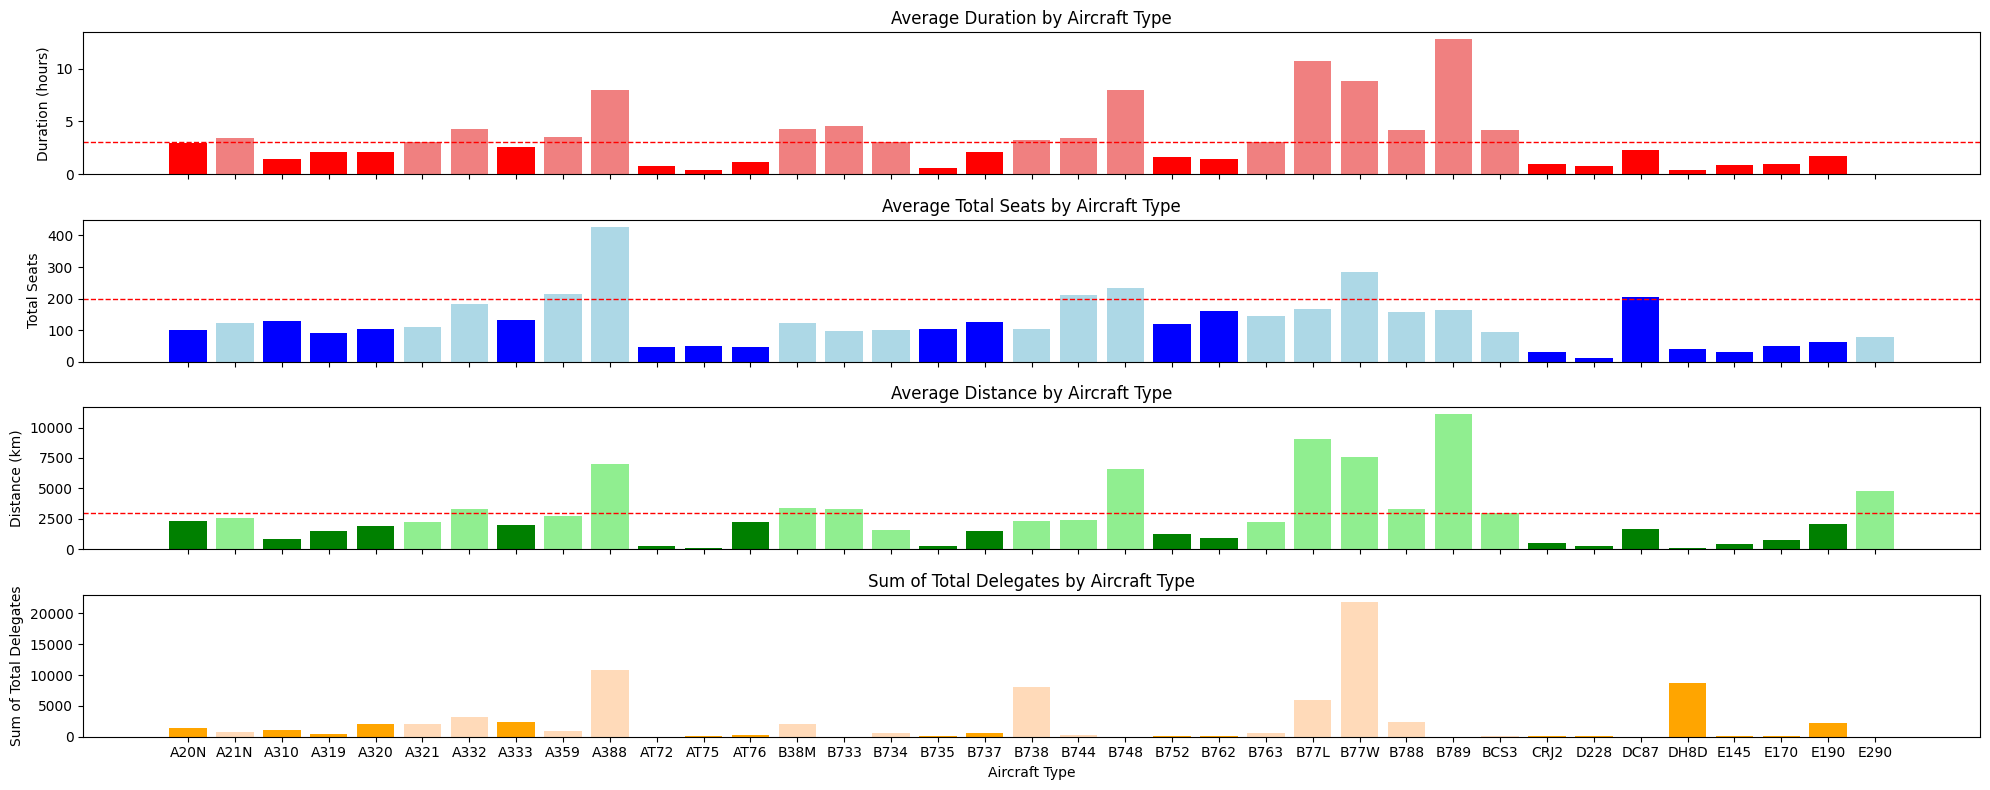

In [72]:

# Create a figure with subplots
fig, axs = plt.subplots(4, 1, figsize=(20, 8), sharex=True)

# Plotting duration_hours
for index, row in grouped_data.iterrows():
    color = 'lightcoral' if row['aircraft_type_icao'] not in short_haul_aircraft else 'red'
    axs[0].bar(row['aircraft_type_icao'], row['duration_hours'], color=color)

axs[0].set_title('Average Duration by Aircraft Type')
axs[0].set_ylabel('Duration (hours)')
axs[0].axhline(y=3, color='red', linestyle='--', linewidth=1)  # Adding the limit line at 8 hours

# Plotting total seats
for index, row in grouped_data.iterrows():
    color = 'lightblue' if row['aircraft_type_icao'] not in short_haul_aircraft else 'blue'
    axs[1].bar(row['aircraft_type_icao'], row['total_seats'], color=color)

axs[1].set_title('Average Total Seats by Aircraft Type')
axs[1].set_ylabel('Total Seats')
axs[1].axhline(y=200, color='red', linestyle='--', linewidth=1)  # Adding the limit line at 200

# Plotting distance
for index, row in grouped_data.iterrows():
    color = 'lightgreen' if row['aircraft_type_icao'] not in short_haul_aircraft else 'green'
    axs[2].bar(row['aircraft_type_icao'], row['distance_km'], color=color)

axs[2].set_title('Average Distance by Aircraft Type')
axs[2].set_ylabel('Distance (km)')
axs[2].axhline(y=3000, color='red', linestyle='--', linewidth=1)  # Adding the limit line at 3000

# Plotting total delegates
for aircraft_type in total_delegates_sum.index:
    color = 'peachpuff' if aircraft_type not in short_haul_aircraft else 'orange'
    axs[3].bar(aircraft_type, total_delegates_sum[aircraft_type], color=color)

axs[3].set_title('Sum of Total Delegates by Aircraft Type')
axs[3].set_xlabel('Aircraft Type')
axs[3].set_ylabel('Sum of Total Delegates')

# Calculate the sum of total delegates for each aircraft type
total_delegates_sum = data_all.groupby('aircraft_type_icao')['total_delegates'].sum()

# Rotate x-axis labels for better readability if necessary
# plt.setp(axs[3].xaxis.get_majorticklabels(), rotation=45)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

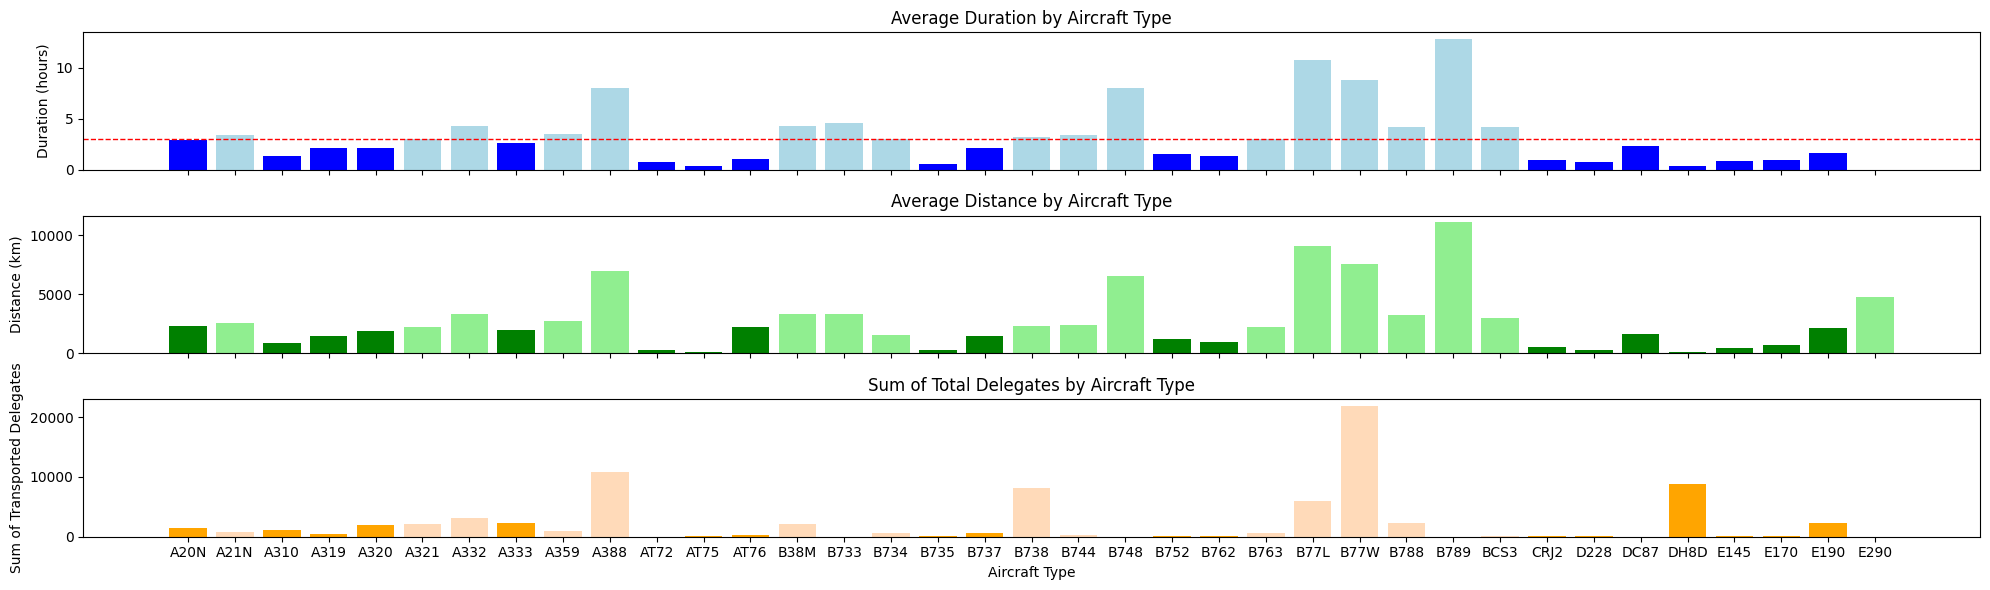

In [78]:
# Create a figure with subplots
fig, axs = plt.subplots(3, 1, figsize=(20, 6),sharex=True)


# # Plotting total seats
# for index, row in grouped_data.iterrows():
#     color = 'lightblue' if row['aircraft_type_icao'] not in short_haul_aircraft else 'blue'
#     axs[0].bar(row['aircraft_type_icao'], row['total_seats'], color=color)

# axs[0].set_title('Average Total Seats by Aircraft Type')
# # axs[0].set_xlabel('Aircraft Type')
# axs[0].set_ylabel('Total Seats')
# axs[0].axhline(y=200, color='red', linestyle='--', linewidth=1)  # Adding the limit line at 200
# Plotting duration_hours
for index, row in grouped_data.iterrows():
    color = 'lightblue' if row['aircraft_type_icao'] not in short_haul_aircraft else 'blue'
    axs[0].bar(row['aircraft_type_icao'], row['duration_hours'], color=color)

axs[0].set_title('Average Duration by Aircraft Type')
axs[0].set_ylabel('Duration (hours)')
axs[0].axhline(y=3, color='red', linestyle='--', linewidth=1)  # Adding the limit line at 8 hours



# Plotting distance
for index, row in grouped_data.iterrows():
    color = 'lightgreen' if row['aircraft_type_icao'] not in short_haul_aircraft else 'green'
    axs[1].bar(row['aircraft_type_icao'], row['distance_km'], color=color)

axs[1].set_title('Average Distance by Aircraft Type')
# axs[1].set_xlabel('Aircraft Type')
axs[1].set_ylabel('Distance (km)')
# axs[1].axhline(y=3000, color='red', linestyle='--', linewidth=1)  # Adding the limit line at 3000


for aircraft_type in total_delegates_sum.index:
    color = 'peachpuff' if aircraft_type not in short_haul_aircraft else 'orange'  # Using lightsalmon for short haul
    axs[2].bar(aircraft_type, total_delegates_sum[aircraft_type], color=color)

axs[2].set_title('Sum of Total Delegates by Aircraft Type')
axs[2].set_xlabel('Aircraft Type')
axs[2].set_ylabel('Sum of Transported Delegates')
#axs[2].tick_params(axis='x', which='both', bottom=True, top=False)  # Show x-axis ticks only for axs[3]

# Calculate the sum of total delegates for each aircraft type
total_delegates_sum = data_all.groupby('aircraft_type_icao')['total_delegates'].sum()






# Rotate x-axis labels for better readability if necessary
# plt.setp(axs[3].xaxis.get_majorticklabels(), rotation=45)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


In [88]:
grouped_data.loc[data_all['is_short_haul'] == False,'aircraft_type_icao'].count()

26

In [96]:
data_all.loc[data_all['is_short_haul'] == True,'distance_km'].sum()

202216.61552421094

In [84]:
data_all.loc[data_all['is_short_haul'] == False,'total_delegates'].sum()

47620

In [94]:
data_all['distance_km'].sum()

1301060.4271685062

In [97]:
1098843/(202216 + 1098843)

0.8445758416797393

# 2. Data Analysis
## 2.1 General

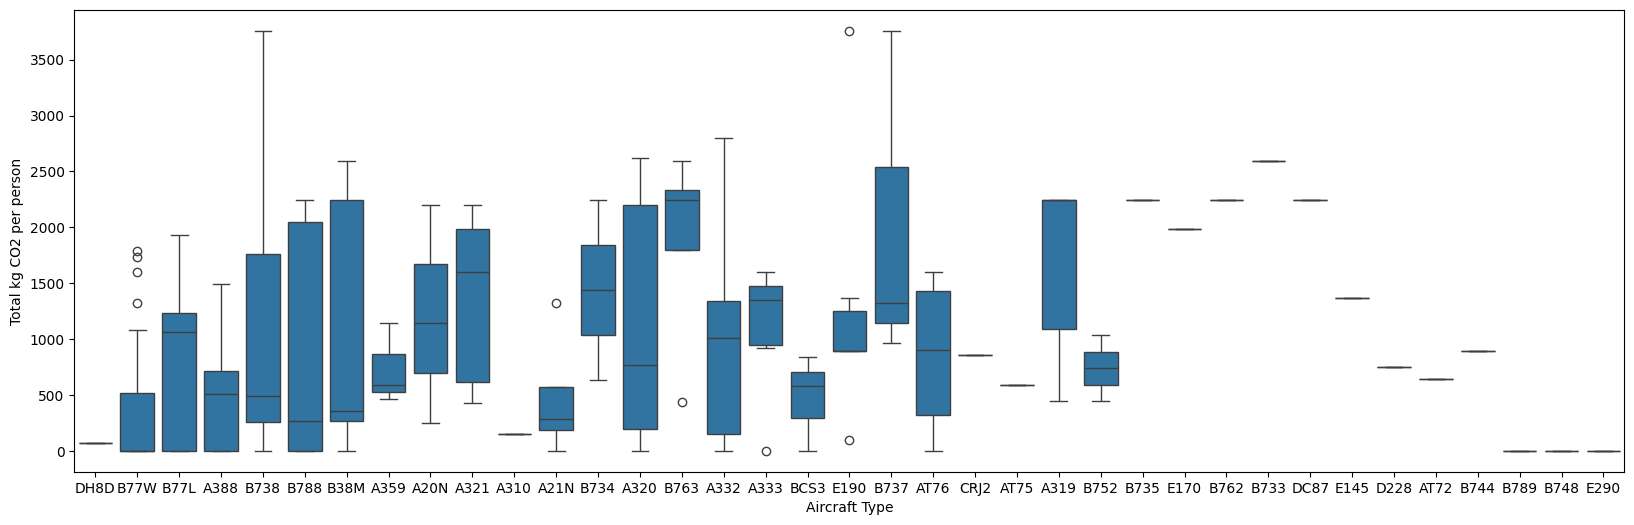

In [98]:
# Boxplot for total_fuel_burn
plt.figure(figsize=(20, 6))
sns.boxplot(x='aircraft_type_icao', y='pp_kg_co2', data=data_all)
# plt.title('Total kg of CO2 per person')
plt.xlabel('Aircraft Type')
plt.ylabel('Total kg CO2 per person')
plt.show()

# # Boxplot for total_fuel_burn
# plt.figure(figsize=(15, 6))
# sns.boxplot(x='aircraft_type_icao', y='pp_g_co2_km', data=data_all)
# # plt.title('Total kg of CO2 per person')
# plt.xlabel('Aircraft Type')
# plt.ylabel('Total g CO2 per km')
# plt.show()

In [99]:
# plt.figure(figsize=(15, 6))

# # Barplot for average value
# sns.barplot(x='aircraft_type_icao', y='pp_g_co2_km', data=data_direct, estimator=lambda x: sum(x) / len(x), color='lightblue')

# # Add values to the top of the bars
# for p in plt.gca().patches:
#     plt.gca().annotate('{:.2f}'.format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
#                 ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
#                 textcoords='offset points')

# plt.xlabel('Aircraft Type')
# plt.ylabel('Total g CO2 per km')

# plt.show()


## 2.2 Split Economy/Business Class

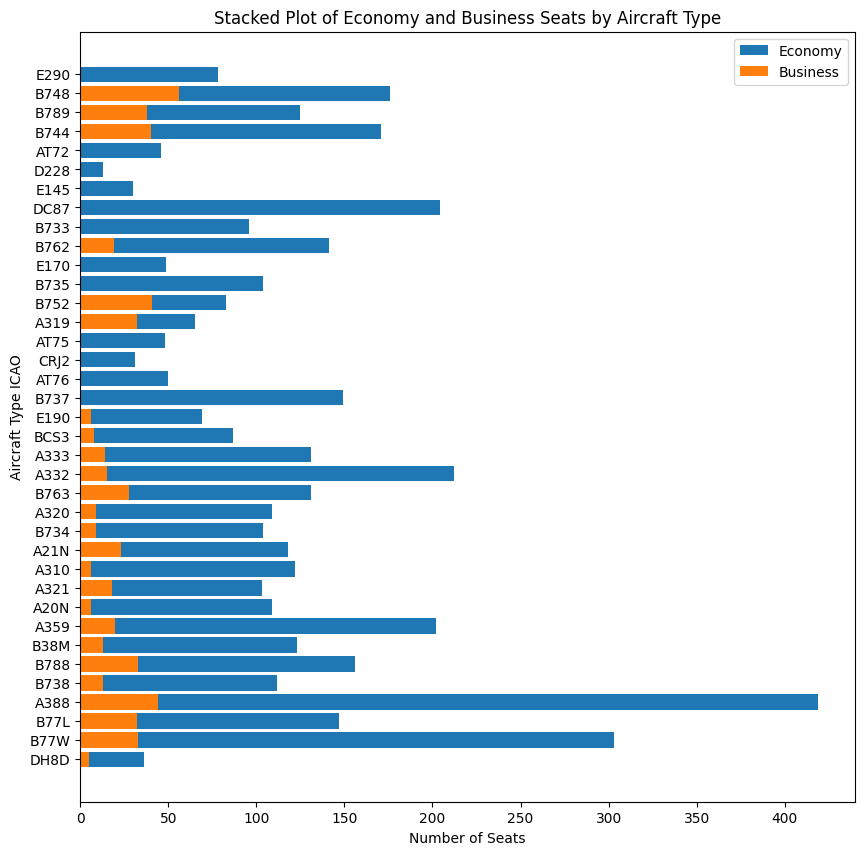

In [100]:

# Plot
plt.figure(figsize=(10, 10))

# Stacked bar plot
plt.barh(data_all['aircraft_type_icao'], data_all['Seats Economy'], label='Economy')
plt.barh(data_all['aircraft_type_icao'], data_all['Seats Business'],  label='Business') # left=data_all['Seats Economy'],

# Labels and title
plt.xlabel('Number of Seats')
plt.ylabel('Aircraft Type ICAO')
plt.title('Stacked Plot of Economy and Business Seats by Aircraft Type')
plt.legend()

# Show plot
plt.show()


### 2.2.1 CO2 Emission Visualisation

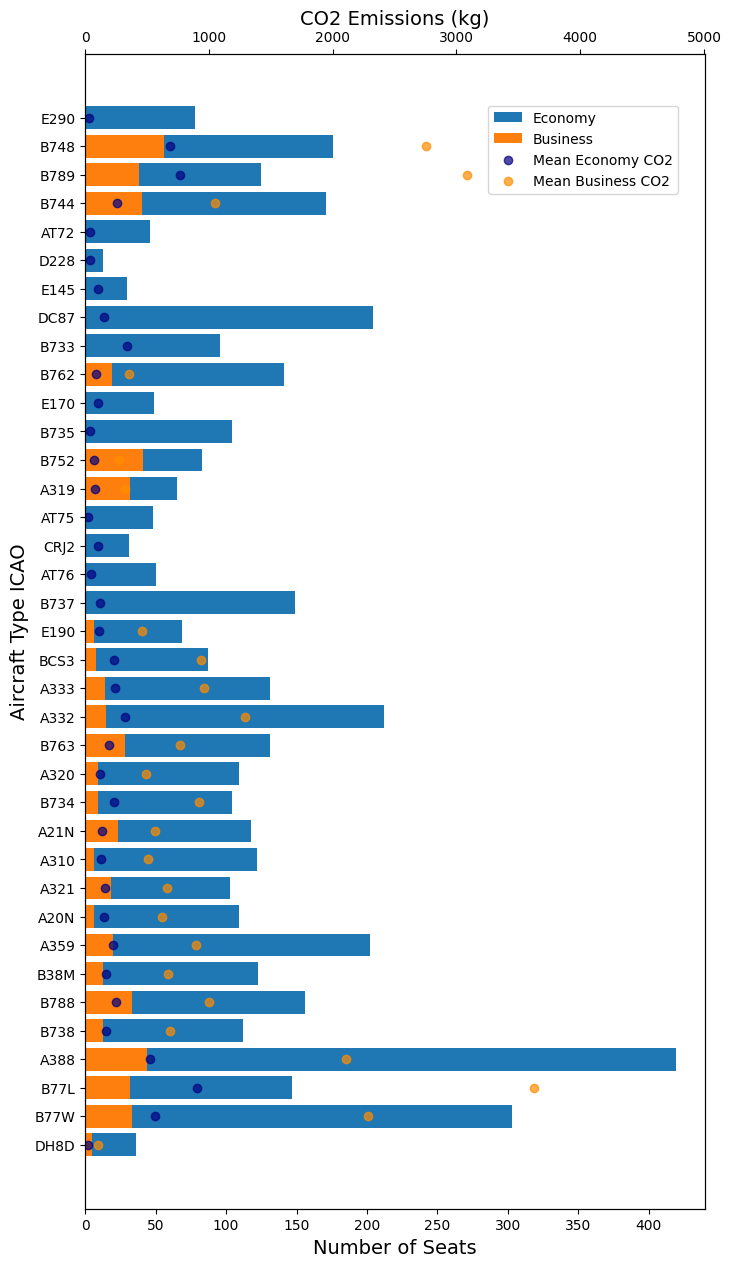

In [101]:
# Calculate mean CO2 emissions for business and economy
mean_business_co2 = data_all.groupby('aircraft_type_icao')['business_co2_pp'].mean()
mean_economy_co2 = data_all.groupby('aircraft_type_icao')['economy_co2_pp'].mean()

# Plot
fig, ax1 = plt.subplots(figsize=(8, 15))

# Stacked bar plot for seats
ax1.barh(data_all['aircraft_type_icao'], data_all['Seats Economy'], label='Economy')
ax1.barh(data_all['aircraft_type_icao'], data_all['Seats Business'], label='Business')

# Labels and title for seats
ax1.set_xlabel('Number of Seats', fontsize=14)
ax1.set_ylabel('Aircraft Type ICAO', fontsize=14)
# ax1.set_title('Stacked Plot of Economy and Business Seats by Aircraft Type', fontsize=16)

# Create a second x-axis for CO2 emissions
ax2 = ax1.twiny()
ax2.set_xlabel('CO2 Emissions (kg)', fontsize=14)

ax2.set_xlim(0, data_all[['business_co2_pp', 'economy_co2_pp']].max().max() + 100)

# Plot mean CO2 emissions as points with darker shades
ax2.scatter(mean_economy_co2, mean_economy_co2.index, color='navy', label='Mean Economy CO2', alpha=0.7)
ax2.scatter(mean_business_co2, mean_business_co2.index, color='darkorange', label='Mean Business CO2', alpha=0.7)

# Add legend
# fig.legend(loc='upper right', bbox_to_anchor=(1, 1))
# ax1.legend(loc='upper right', bbox_to_anchor=(1, 1.2))
fig.legend(loc='upper right', bbox_to_anchor=(0.875, 0.85))

# Show plot
plt.show()


# 3 Calculating total emissions

In [102]:
# data_all['total_co2'] = (data_all['total_delegats_inc_hub'] / (data_all['Seats Business'] + data_all['Seats Economy'])) * data_all['co2_kg'] * 2
print(data_all['total_co2'].sum())

97741251.86562386


In [103]:
data_all[['origin_airport','destination_airport','total_delegats_inc_hub','aircraft_type_icao','co2_kg',
          'Split Econ/Busi','Seats Economy','Seats Business','economy_co2_pp', 'business_co2_pp', 
          'is_short_haul','total_delegats_inc_hub', 'total_co2']].iloc[:3]

,origin_airport,destination_airport,total_delegats_inc_hub,aircraft_type_icao,co2_kg,Split Econ/Busi,Seats Economy,Seats Business,economy_co2_pp,business_co2_pp,is_short_haul,total_delegats_inc_hub,total_co2
0,OMAA,OMDB,8786,DH8D,1475.189208,0.128205,36,5,26.283995,105.793079,True,8786,6.322445e+05
1,SBGR,OMDB,3618,B77W,369691.457386,0.098361,303,33,848.256657,3414.233043,False,3618,7.961570e+06
2,ZBAA,OMDB,2640,B77L,164527.903430,0.180672,125,28,692.166190,2785.968916,False,2640,5.677826e+06


In [112]:

condition

0      False
1       True
2       True
3       True
4       True
       ...  
271     True
272     True
273     True
274     True
275     True
Name: is_short_haul, Length: 273, dtype: bool

In [113]:
data_all['economy_new'] = 0.0
data_all['business_new'] = 0.0


# SHORT FLIGHTS
condition_short = data_all['is_short_haul'] == False
sensitivity_value = 0.05 # Assumption that 5% change to economy for medium to long haul flights (>3 hours)

data_all.loc[condition_short,'economy_new'] = data_all.loc[condition_short,'Seats Economy'] + data_all.loc[condition_short,'Seats Business'] * sensitivity_value
data_all.loc[condition_short,'business_new'] = data_all.loc[condition_short,'Seats Business'] * (1 - sensitivity_value)


# LONG FLIGHTS
condition_long = data_all['is_short_haul'] == True
sensitivity_value_short = 0.3 # Assumption that 30% change to economy for short flights (<3 hours)

data_all.loc[condition_long,'economy_new'] = data_all.loc[condition_long,'Seats Economy'] + data_all.loc[condition_long,'Seats Business'] * sensitivity_value_short
data_all.loc[condition_long,'business_new'] = data_all.loc[condition_long,'Seats Business'] * (1 - sensitivity_value_short)


new_co2_economy = data_all['economy_new'] * data_all['economy_co2_pp']
new_co2_business = data_all['business_new'] * data_all['business_co2_pp']

# new emission for whole flight
data_all['flight_co2_reduced'] = new_co2_economy + new_co2_business

# Some values were 0, if business class was 0
missing_rows = data_all['flight_co2_reduced'].isnull() | (data_all['flight_co2_reduced'] == 0)
data_all.loc[missing_rows, 'flight_co2_reduced'] = data_all.loc[missing_rows, 'co2_kg']

data_all['total_co2_new'] = (data_all['total_delegats_inc_hub'] / (data_all['Seats Business'] + data_all['Seats Economy'])) * data_all['flight_co2_reduced'] * 2
data_all['total_co2_new'].sum()

95858687.91290657

Calculate the effect of short and medium/long flights alone 

In [105]:
data_all.loc[data_all['is_short_haul'] == True,'economy_short'] = data_all.loc[data_all['is_short_haul'] == True,'Seats Economy'] + data_all.loc[data_all['is_short_haul'] == True,'Seats Business'] * sensitivity_value_short
data_all.loc[data_all['is_short_haul'] == True,'business_short'] = data_all.loc[data_all['is_short_haul'] == True,'Seats Business'] * (1 - sensitivity_value_short)

new_co2_economy = data_all['economy_short'] * data_all['economy_co2_pp']# / (data_all['business_new'] + data_all['economy_new'])
new_co2_business = data_all['business_short'] * data_all['business_co2_pp']# /  (data_all['business_new'] + data_all['economy_new'])


data_all['flight_co2_reduced_long'] = new_co2_economy + new_co2_business

# Some values were 0, if business class was 0
missing_rows = data_all['flight_co2_reduced_long'].isnull() | (data_all['flight_co2_reduced_long'] == 0)
data_all.loc[missing_rows, 'flight_co2_reduced_long'] = data_all.loc[missing_rows, 'co2_kg']

data_all['total_co2_long'] = (data_all['total_delegats_inc_hub'] / (data_all['Seats Business'] + data_all['Seats Economy'])) * data_all['flight_co2_reduced_long'] * 2
data_all['total_co2_long'].sum()

96987263.97770672

In [106]:
data_all.loc[data_all['is_short_haul'] == False,'economy_long'] = data_all.loc[data_all['is_short_haul'] == False,'Seats Economy'] + data_all.loc[data_all['is_short_haul'] == False,'Seats Business'] * sensitivity_value
data_all.loc[data_all['is_short_haul'] == False,'business_long'] = data_all.loc[data_all['is_short_haul'] == False,'Seats Business'] * (1 - sensitivity_value)

new_co2_economy = data_all['economy_long'] * data_all['economy_co2_pp']# / (data_all['business_new'] + data_all['economy_new'])
new_co2_business = data_all['business_long'] * data_all['business_co2_pp']# /  (data_all['business_new'] + data_all['economy_new'])



data_all['flight_co2_reduced_short'] = new_co2_economy + new_co2_business

# Some values were 0, if business class was 0
missing_rows = data_all['flight_co2_reduced_short'].isnull() | (data_all['flight_co2_reduced_short'] == 0)
data_all.loc[missing_rows, 'flight_co2_reduced_short'] = data_all.loc[missing_rows, 'co2_kg']

data_all['total_co2_short'] = (data_all['total_delegats_inc_hub'] / (data_all['Seats Business'] + data_all['Seats Economy'])) * data_all['flight_co2_reduced_short'] * 2
data_all['total_co2_short'].sum()

96612675.80082372

In [107]:
data_all['flight_co2_reduced_short'].mean() / data_all['co2_kg'].mean()

0.9888027869861936

In [108]:
(data_all['total_co2'].sum() - data_all['total_co2_short'].sum()) + (data_all['total_co2'].sum() - data_all['total_co2_long'].sum())

1882563.9527172893

## Visualisation

In [109]:
data_all['total_co2'].sum()

97741251.86562386

In [110]:
import plotly.graph_objects as go

# Calculate the sum of total_co2
current_status = data_all['total_co2'].sum()

# Calculate the reductions
reduction_long = data_all['total_co2_long'].sum() - current_status 
reduction_short = data_all['total_co2_short'].sum() - current_status

# Calculate percentage reductions
percentage_reduction_long = (reduction_long / current_status) * 100
percentage_reduction_short = (reduction_short / current_status) * 100

total_percentage_reduction = percentage_reduction_long + percentage_reduction_short


# Create the waterfall chart
fig = go.Figure(go.Waterfall(
    name="Change in Total CO2",
    orientation="v",
    measure=["relative", "relative", "relative"],
    x=["Current Status", "Long haul \n(-5%)", "Short haul\n(-30%)"],
    y=[current_status, reduction_long, reduction_short],
    connector={"line": {"color": "rgb(63, 63, 63)"}},
    increasing={"marker": {"color": "red"}},  # Change color for increases (reductions)
    decreasing={"marker": {"color": "green"}},    # Change color for decreases (total_co2)
))

# Add annotations for percentage reductions
annotations = [
    dict(
        x=1,  # x-coordinate of the annotation
        y=current_status - 5000000,  # y-coordinate of the annotation
        text=f"{percentage_reduction_long:.2f}%",  # Text of the annotation
        showarrow=False,  # Hide arrow
        font=dict(color="black", size=18, family="Aharoni")  # Font settings with Aharoni font
    ),
    dict(
        x=2,  # x-coordinate of the annotation
        y= current_status - 7000000,  # y-coordinate of the annotation
        text=f"{percentage_reduction_short:.2f}%",  # Text of the annotation
        showarrow=False,  # Hide arrow
        font=dict(color="black", size=18, family="Aharoni")  # Font settings with Aharoni font
    ),
    dict(
        x=1.5,  # x-coordinate of the annotation
        y= 50000000,  # y-coordinate of the annotation
        # y=current_status + reduction_long + reduction_short - 500000,  # y-coordinate of the annotation
        text=f"Total % Reduction: {total_percentage_reduction:.2f}%",  # Text of the annotation
        showarrow=False,  # Do not show arrow
        font=dict(color="black", size=18, family="Aharoni")  # Font settings with Aharoni font  # Font settings
    )
]

adjust = 3000000
# Update layout with annotations
fig.update_layout(
    width=500, height=600,
    # title="Waterfall Diagram of Total CO2",
    showlegend=False,
    annotations=annotations,  # Add annotations
    yaxis=dict(range=[0, current_status + adjust])  # Adjust range as needed
    # yaxis=dict(range=[current_status - adjust, current_status + adjust/2])  # Adjust range as needed
)

# Show the plot
fig.show()


In [ ]:
# Calculate the sum of total_co2
current_status = data_all['total_co2'].sum()

# Calculate the reductions
reduction_long = data_all['total_co2_long'].sum() - current_status 
reduction_short = data_all['total_co2_short'].sum() - current_status

# Calculate percentage reductions
percentage_reduction_long = (reduction_long / current_status) * 100
percentage_reduction_short = (reduction_short / current_status) * 100

total_percentage_reduction = percentage_reduction_long + percentage_reduction_short


# Create the waterfall chart
fig = go.Figure(go.Waterfall(
    name="Change in Total CO2",
    orientation="v",
    measure=["relative", "relative", "relative"],
    x=["Current Status", "Long haul \n(-5%)", "Short haul\n(-30%)"],
    y=[current_status, reduction_long, reduction_short],
    connector={"line": {"color": "rgb(63, 63, 63)"}},
    increasing={"marker": {"color": "red"}},  # Change color for increases (reductions)
    decreasing={"marker": {"color": "green"}},    # Change color for decreases (total_co2)
))

# Add annotations for percentage reductions
annotations = [
    dict(
        x=1,  # x-coordinate of the annotation
        y=current_status + reduction_long / 2,  # y-coordinate of the annotation
        text=f"{percentage_reduction_long:.2f}%",  # Text of the annotation
        showarrow=False,  # Hide arrow
        font=dict(color="white", size=18, family="Aharoni")  # Font settings with Aharoni font
    ),
    dict(
        x=2,  # x-coordinate of the annotation
        y= current_status + reduction_long + reduction_short/ 2,  # y-coordinate of the annotation
        text=f"{percentage_reduction_short:.2f}%",  # Text of the annotation
        showarrow=False,  # Hide arrow
        font=dict(color="white", size=18, family="Aharoni")  # Font settings with Aharoni font
    ),
    dict(
        x=1.5,  # x-coordinate of the annotation
        y=current_status + reduction_long + reduction_short - 500000,  # y-coordinate of the annotation
        text=f"Total % Reduction: {total_percentage_reduction:.2f}%",  # Text of the annotation
        showarrow=False,  # Do not show arrow
        font=dict(color="black", size=18, family="Aharoni")  # Font settings with Aharoni font  # Font settings
    )
]

adjust = 3000000
# Update layout with annotations
fig.update_layout(
    width=500, height=600,
    # title="Waterfall Diagram of Total CO2",
    showlegend=False,
    annotations=annotations,  # Add annotations
    yaxis=dict(range=[current_status - adjust, current_status + adjust/2])  # Adjust range as needed
)

# Show the plot
fig.show()
